In [1]:
import iris, windspharm
import warnings
import numpy as np
import iris.plot as iplt

import iris.quickplot as qplt

import matplotlib.pyplot as plt
import cartopy.crs as ccrs  
import mo_pack
from matplotlib import ticker, cm
import iris.analysis.cartography
import aeolus
from aeolus.coord import volume_weights_cube, area_weights_cube, coord_delta_to_cube

In [2]:
warnings.filterwarnings("ignore")


# Import the climate and chemistry data for 3 runs

In [3]:
pcb_baddhox = iris.load('../data_b/pcb_bhox_muscles_7440_120.nc')
pcb_bnox = iris.load('../data_b/pcb_bnox_musc_7440_120_2.nc')
pcb_bchap = iris.load('../data_b/pcb_bchap_musc_st_7440_120.nc')

In [4]:
o3mmr_chap = pcb_bchap.extract_cube('O3 MASS MIXING RATIO')
avto3mmr_chap = o3mmr_chap.collapsed('t', iris.analysis.MEAN)*29.3/48
o3mmr_hox = pcb_baddhox.extract_cube('O3 MASS MIXING RATIO')
avto3mmr_hox = o3mmr_hox.collapsed('t', iris.analysis.MEAN)*29.3/48
o3mmr_nox = pcb_bnox.extract_cube('O3 MASS MIXING RATIO')
avto3mmr_nox = o3mmr_nox.collapsed('t', iris.analysis.MEAN)*29.3/48


# Some standard cube operations

In [5]:
from iris.util import broadcast_to_shape, guess_coord_axis, is_regular
from iris.analysis.cartography import wrap_lons

def zonal_mean(cube, lon_name="longitude"):
    """
    Calculate cube's zonal average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lon_name: str, optional
        Name of the longitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    cube_mean = cube.collapsed(lon_name, iris.analysis.MEAN)
    return cube_mean


def meridional_mean(cube, lat_name="latitude"):
    """
    Calculate cube's meridional average.
    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with a latitude coordinate.
    lat_name: str, optional
        Name of the latitude coordinate.
    Returns
    -------
    iris.cube.Cube
        Collapsed cube.
    """
    coslat = np.cos(np.deg2rad(cube.coord(lat_name).points))
    coslat2d = iris.util.broadcast_to_shape(
        coslat, cube.shape, cube.coord_dims(lat_name)
    )
    cube_mean = (cube * coslat2d).collapsed(lat_name, iris.analysis.SUM) / np.sum(
        coslat
    )
    return cube_mean

def cube_min(cube):
    a=cube.collapsed('latitude', iris.analysis.MIN)
    b=a.collapsed('longitude', iris.analysis.MIN)
    return b.data

def cube_max(cube):
    a=cube.collapsed('latitude', iris.analysis.MAX)
    b=a.collapsed('longitude', iris.analysis.MAX)
    return b.data

def deltacube(cube1,cube2):
    cube3 = (cube1-cube2)
    return cube3


 
def volume_weights_cube2(cube, r_planet=None, normalize=False, model=aeolus.model.um):
    """
    Create a cube of volume weights from a grid of a given cube.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude, latitude and height coordinates
    r_planet: float, optional
        Radius of the planet (m). If not given, an attempt is made
        to get it from the cube metadata.
    normalize: bool, optional
        Normalize the data.
    model: aeolus.model.Model, optional
        Model class with relevant coordinate names.

    Returns
    -------
    iris.cube.Cube
        Cube of area weights with the same metadata as the input cube
    """
    area_cube = area_weights_cube(cube, r_planet=r_planet, normalize=normalize, model=model)
    height_deltas = coord_delta_to_cube(cube, model.z, normalize=normalize)
    volume = area_cube * height_deltas
    if normalize:
        volume.rename("normalized_volume_weights")
        volume.convert_units("1")
    else:
        volume.rename("volume_weights")
        volume.units == "m**3"
    return volume

def _is_longitude_global(lon_points):
    """Return True if array of longitudes covers the whole sphere."""
    dx = np.diff(lon_points)[0]  # assume regular grid
    case_0_360 = ((lon_points[0] - dx) <= 0) and ((lon_points[-1] + dx) >= 360)
    case_pm180 = ((lon_points[0] - dx) <= -180) and ((lon_points[-1] + dx) >= 180)
    return case_0_360 or case_pm180

def roll_cube_pm180(cube_in):
    """
    Take a cube spanning 0...360 degrees in longitude and roll it to -180...180 degrees.

    Works with global model output, and in some cases for regional.

    Parameters
    ----------
    cube: iris.cube.Cube
        Cube with longitude and latitude coordinates.
    model: aeolus.model.Model, optional
        Model class with a relevant longitude coordinate name.

    Returns
    -------
    iris.cube.Cube

    See also
    --------
    aeolus.coord.roll_cube_0_360
    """
    cube = cube_in.copy()
    #coord_name = model.x  # get the name of the longitude coordinate
    xcoord = cube.coord('longitude')
    if (xcoord.points >= 0.0).all():
        assert is_regular(xcoord), "Operation is only valid for a regularly spaced coordinate."
        if _is_longitude_global(xcoord.points):
            # Shift data symmetrically only when dealing with global cubes
            cube.data = np.roll(cube.data, len(xcoord.points) // 2, axis=-1)

        if xcoord.has_bounds():
            bounds = wrap_lons(xcoord.bounds, -180, 360)  # + subtract
            bounds = bounds[bounds[:, 0].argsort(axis=0)]
        else:
            bounds = None
        cube.replace_coord(
            xcoord.copy(points=np.sort(wrap_lons(xcoord.points, -180, 360)), bounds=bounds)
        )
    else:
        # Nothing to do, the cube is already centered on 0 longitude
        # unless there is something wrong with longitude
        msg = f"Incorrect {coord_name} values: from {xcoord.points.min()} to {xcoord.points.max()}"
        assert ((xcoord.points >= -180.0) & (xcoord.points <= 180.0)).all(), msg
    return cube

def cuberoll_merid(cube_in):
    roll = roll_cube_pm180(cube_in)
    #roll_merid=meridional_mean(roll)
    return roll

# Hemispheric separation for Ox-HOx-NOx runs

In [6]:
def hemisphere_sep(cube):
    daycube=cube.extract(iris.Constraint(longitude=lambda v: v > 270 or v <= 90,
                                    latitude=lambda v: -90 <= v <= 90))
    nightcube=cube.extract(iris.Constraint(longitude=lambda v: 90 < v <= 270,
                                    latitude=lambda v: -90 <= v <= 90)) 
    daymean = meridional_mean(zonal_mean(daycube))
    nightmean = meridional_mean(zonal_mean(nightcube)) 
    return daymean, nightmean

o3mmr_chap_mday, o3mmr_chap_mnight = hemisphere_sep(avto3mmr_chap)
o3mmr_hox_mday, o3mmr_hox_mnight = hemisphere_sep(avto3mmr_hox)
o3mmr_nox_mday, o3mmr_nox_mnight = hemisphere_sep(avto3mmr_nox)


# Vertical O$_3$ profile: Figure 5 in Braam et al. (2022)

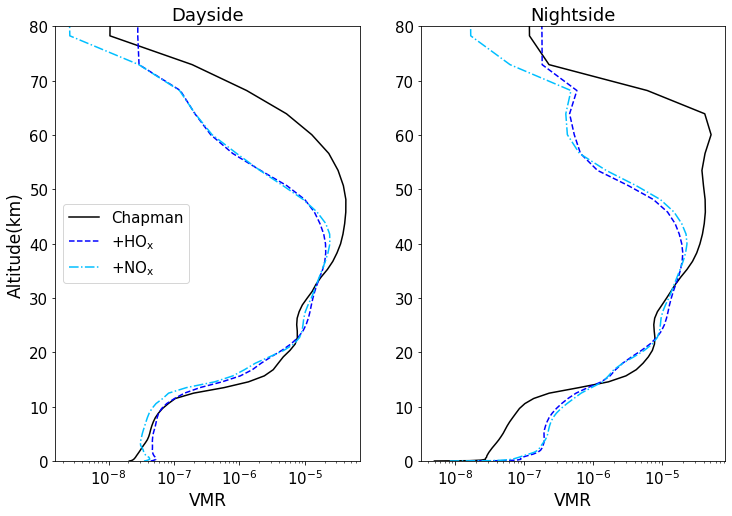

In [7]:
#Dayside
plt.figure(figsize=(12,8))
plt.subplot(1, 2, 1)
iplt.plot(o3mmr_chap_mday[:], o3mmr_chap_mday.coord("Hybrid height")/1000, color='black', ls='-', label='Chapman')
iplt.plot(o3mmr_hox_mday[:], o3mmr_hox_mday.coord("Hybrid height")/1000, color='blue', ls='--', label=r'+HO$_\mathrm{x}$')
iplt.plot(o3mmr_nox_mday[:], o3mmr_nox_mday.coord("Hybrid height")/1000, color='deepskyblue', ls='dashdot', label=r'+NO$_\mathrm{x}$')
plt.gca().set_title('Dayside', fontsize=18)
plt.xlabel('VMR', fontsize=17)
plt.ylabel('Altitude(km)', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(loc='best', fontsize=15)
plt.ylim(0,80)
plt.xscale('log')

#Nightside
plt.subplot(1, 2, 2)
iplt.plot(o3mmr_chap_mnight[:], o3mmr_chap_mnight.coord("Hybrid height")/1000, color='black', ls='-', label='Chapman')
iplt.plot(o3mmr_hox_mnight[:], o3mmr_hox_mnight.coord("Hybrid height")/1000, color='blue', ls='--', label=r'+HO$_\mathrm{x}$')
iplt.plot(o3mmr_nox_mnight[:], o3mmr_nox_mnight.coord("Hybrid height")/1000, color='deepskyblue', ls='dashdot', label=r'+NO$_\mathrm{x}$')
plt.gca().set_title('Nightside', fontsize=18)
plt.xlabel('VMR', fontsize=17)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,80)
plt.xscale('log')
plt.show()

